colourmaps
https://www.pythonpool.com/matplotlib-cmap/#:~:text=%20Matplotlib%20cmap%20with%20its%20Implementation%20in%20Python,in%20lightness%20and%20possibly%20saturation%20of...%20More%20
plotting colour based on Z value
https://www.statology.org/matplotlib-scatterplot-color-by-value/#:~:text=The%20following%20code%20shows%20how%20to%20create%20a,plt%20%23create%20scatterplot%20plt.scatter%28df.x%2C%20df.y%2C%20s%3D200%2C%20c%3Ddf.z%2C%20cmap%3D%27gray%27%29

In [1]:
#load in data
import pandas as pd

#ground truth
gt_path = 'D:/datasets/soilHyperspec/train_data/train_data/train_gt.csv'

#MaskedTransformed data
mRx_path = r'C:\Users\oakle\OneDrive - University of Lincoln\uniProjects\soil\remote_sensing_hyperspectral_soil-main\remote_sensing_hyperspectral_soil-main\savedData\maskedRx.csv'

#FullImTransformed data
rx_path = r'C:\Users\oakle\OneDrive - University of Lincoln\uniProjects\soil\remote_sensing_hyperspectral_soil-main\remote_sensing_hyperspectral_soil-main\savedData\Rx.csv'

gt_df = pd.read_csv(gt_path)

mRx_df = pd.read_csv(mRx_path,header=None).values

rx_df = pd.read_csv(rx_path,header=None).values

# Treating data as individual pixels

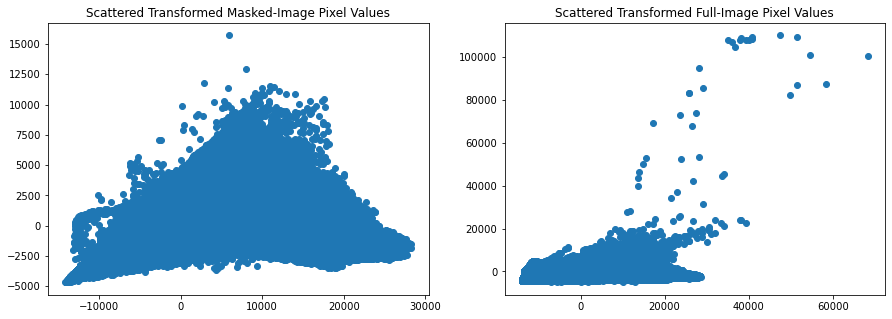

In [2]:
#Show transformed masked pixels vs unmasked pixels
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Scattered Transformed Masked-Image Pixel Values")
plt.scatter(mRx_df[:,0],mRx_df[:,1])

plt.subplot(1, 2, 2)
plt.title("Scattered Transformed Full-Image Pixel Values")
plt.scatter(rx_df[:,0],rx_df[:,1])

## Through indexing get according pixel dependant variables

In [3]:
#Get sizes of full images & masked images
import numpy as np
from tqdm.notebook import tqdm
import os

sizes = [] #index list for full image array (list of sizes for each image)
maskedIndexing = [] #index list for masked image array (list of unmasked-sizes for each image)

for file in tqdm(os.listdir('D:/datasets/soilHyperspec/train_data/train_data/train_data')):
    if file == '.DS_Store':
        continue
    with np.load('D:/datasets/soilHyperspec/train_data/train_data/train_data/' + file) as npz:
        arr = np.ma.MaskedArray(**npz)
        maskedIndexing.append(arr[0,:,:].count())
        sizes.append(arr.shape[1:3])
        del(arr)
        
sizeIndexing = [i[0]*i[1] for i in sizes]

  0%|          | 0/1733 [00:00<?, ?it/s]

In [4]:
#adds corresponding pixel 'y' values to dataframe
def expandDataframe(pcaDF, GT_DATAFRAME, indexing):
    pH = list(GT_DATAFRAME['pH'].values)
    P = list(GT_DATAFRAME['P'].values)
    K = list(GT_DATAFRAME['K'].values)
    Mg = list(GT_DATAFRAME['Mg'].values)
    
    pHExpanded = []
    PExpanded = []
    KExpanded = []
    MgExpanded = []
    
    for i in range(0,len(indexing)): #[121,...]
        for j in range(0,indexing[i]):#[0,1,...,121]
            #add pH value to list
            pHExpanded.append(pH[i])
            PExpanded.append(P[i])
            KExpanded.append(K[i])
            MgExpanded.append(Mg[i])
        
    #add extra column to dataframe
    expandedDF = pd.DataFrame({'PCA1':pcaDF[:,0],
                              'PCA2':pcaDF[:,1],
                              'pH': pHExpanded,
                              'P': PExpanded,
                              'K': KExpanded,
                              'Mg': MgExpanded})
    
    return expandedDF

## Full Image pixels

In [5]:
expandedDF = expandDataframe(rx_df, gt_df,sizeIndexing)

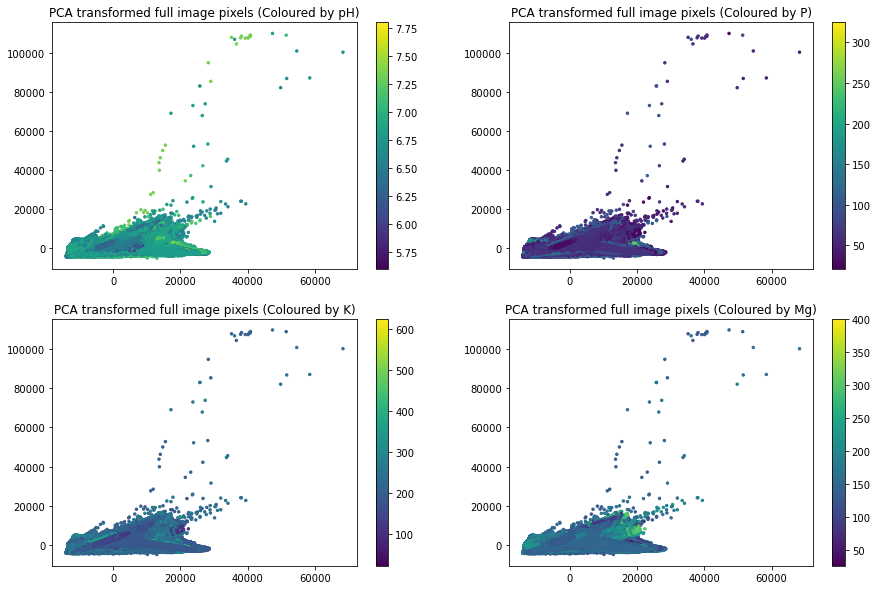

In [6]:
plt.figure(figsize=(15, 10))

depVars = ['pH', 'P' , 'K', 'Mg']

for i in range(0, len(depVars)):
    plt.subplot(2, 2, i+1)
    plt.scatter(expandedDF['PCA1'], expandedDF['PCA2'], s = 6, c=expandedDF[depVars[i]], cmap='viridis')
    plt.title(f"PCA transformed full image pixels (Coloured by {depVars[i]})")
    plt.colorbar()


## Masked Image Pixels

In [7]:
maskedExpandedDF = expandDataframe(mRx_df, gt_df,maskedIndexing)

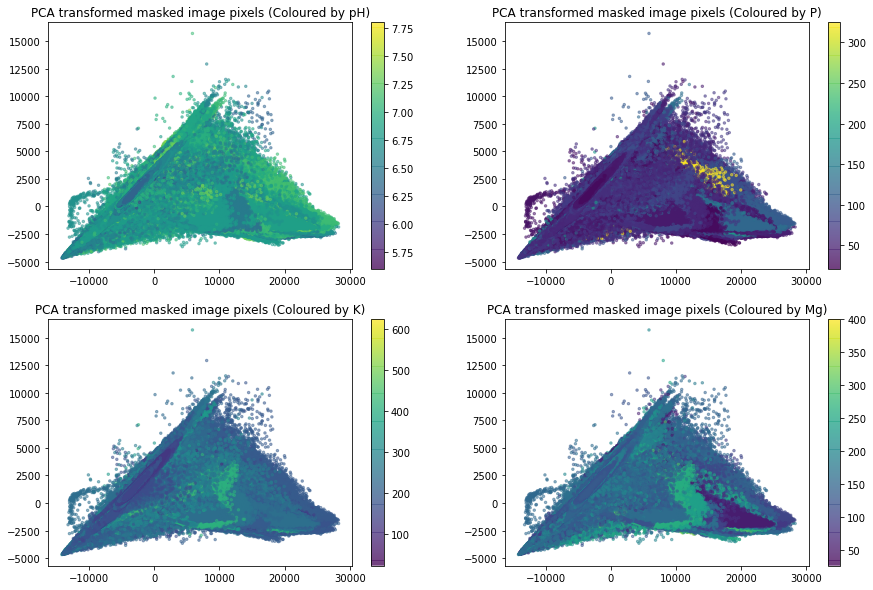

In [8]:
plt.figure(figsize=(15, 10))
for i in range(0, len(depVars)):
    plt.subplot(2, 2, i+1)
    plt.scatter(maskedExpandedDF['PCA1'], maskedExpandedDF['PCA2'], s = 6, c=maskedExpandedDF[depVars[i]], alpha = 0.5, cmap='viridis')
    plt.title(f"PCA transformed masked image pixels (Coloured by {depVars[i]})")
    plt.colorbar()

# Treating data as Images (Averaged PCA1 & PCA2 Value)

In [9]:
#get average/median PCA1 & PCA2 per image
from statistics import mean, median

def centralPCAs(pcaDF,indexing, measure = 'mean'):
    pooledPCA1 = []
    pooledPCA2 = []

    pixelsSeen = 0 #aids in indexing(cuts off values already averaged and added to list) 

    #loop through indexing
    for i in tqdm(range(0,len(indexing))):
        ind = indexing[i] # save index
        maxIndex = pixelsSeen + ind #create start and end index values to loop through 
        minIndex = pixelsSeen
        pca1 = []
        pca2 = []
        for j in range(minIndex,maxIndex): # loops through defined index values
            pca1.append(pcaDF[:,0][j])
            pca2.append(pcaDF[:,1][j])
        
        if measure == 'mean':
            #get average
            pooledPCA1.append(mean(pca1))
            pooledPCA2.append(mean(pca2))
        if measure == 'median':
            #get median
            pooledPCA1.append(median(pca1))
            pooledPCA2.append(median(pca2))
            
            
        pixelsSeen += ind #move along pixels to next 'image' bunch
    
    return pooledPCA1, pooledPCA2

## Full Images

In [10]:
avgPCA1, avgPCA2 = centralPCAs(rx_df,sizeIndexing)

  0%|          | 0/1732 [00:00<?, ?it/s]

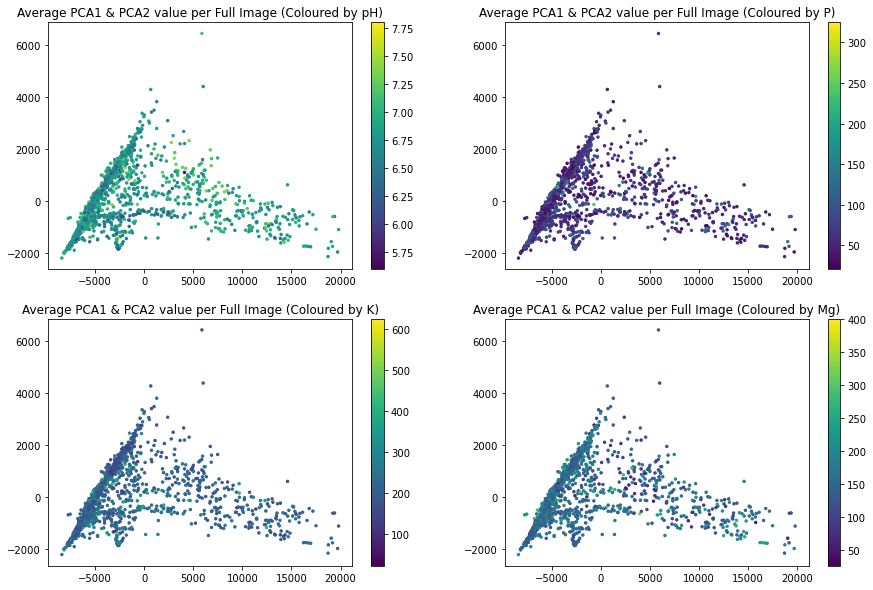

In [11]:
plt.figure(figsize=(15, 10))
for i in range(0, len(depVars)):
    plt.subplot(2, 2, i+1)
    plt.scatter(avgPCA1, avgPCA2, s = 6, c=gt_df[depVars[i]], cmap='viridis')
    plt.title(f"Average PCA1 & PCA2 value per Full Image (Coloured by {depVars[i]})")
    plt.colorbar()

# Masked Images

In [12]:
maAvgPCA1, maAvgPCA2 = centralPCAs(mRx_df,maskedIndexing)

  0%|          | 0/1732 [00:00<?, ?it/s]

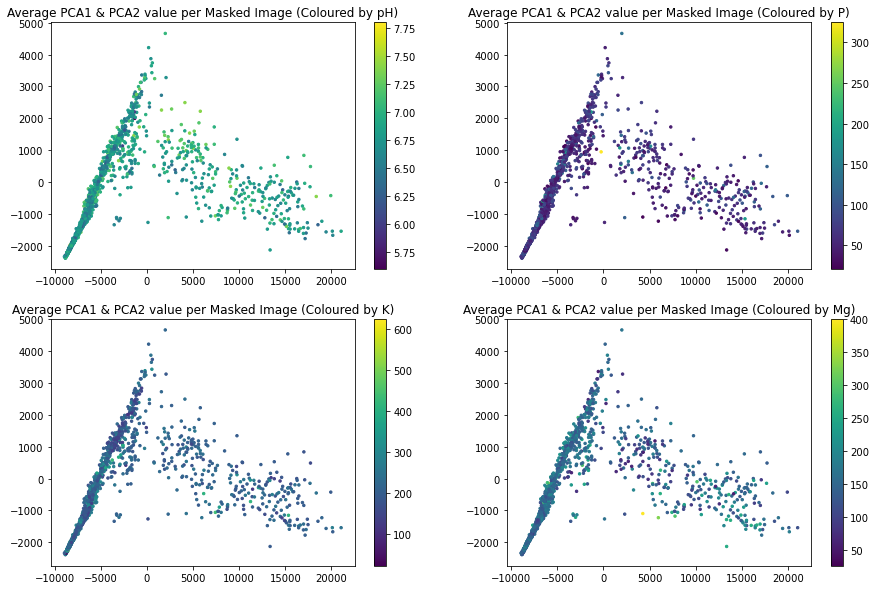

In [13]:
#plot average PCA value(s) for each image
plt.figure(figsize=(15, 10))
for i in range(0, len(depVars)):
    plt.subplot(2, 2, i+1)
    plt.scatter(maAvgPCA1, maAvgPCA2, s = 6, c=gt_df[depVars[i]], cmap='viridis')
    plt.title(f"Average PCA1 & PCA2 value per Masked Image (Coloured by {depVars[i]})")
    plt.colorbar()
    
    #histogram of ground truth values (dataset notebook, np.hist)

In [14]:
medAvgPCA1, medAvgPCA2 = centralPCAs(mRx_df,maskedIndexing,'median')

  0%|          | 0/1732 [00:00<?, ?it/s]

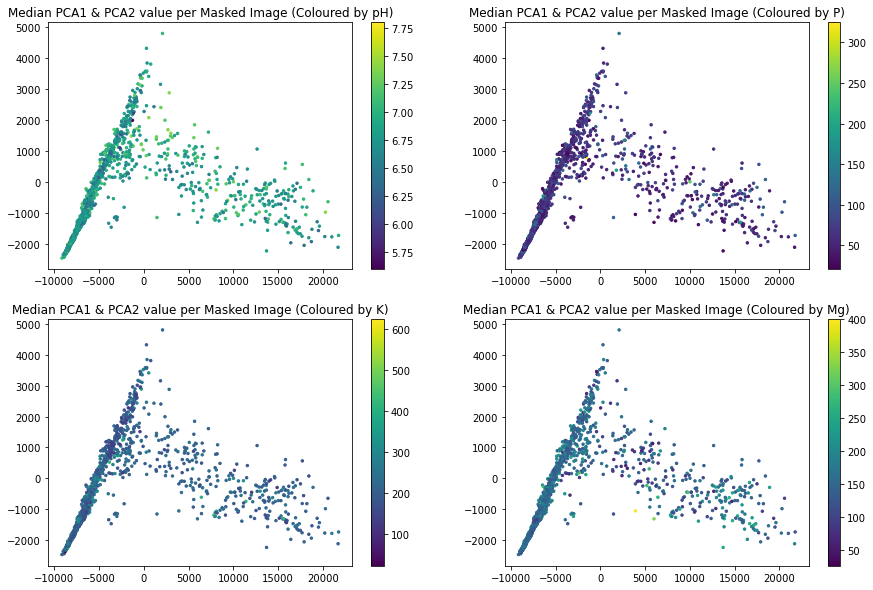

In [15]:
#plot median PCA value(s) for each image
plt.figure(figsize=(15, 10))
for i in range(0, len(depVars)):
    plt.subplot(2, 2, i+1)
    plt.scatter(medAvgPCA1, medAvgPCA2, s = 6, c=gt_df[depVars[i]], cmap='viridis')
    plt.title(f"Median PCA1 & PCA2 value per Masked Image (Coloured by {depVars[i]})")
    plt.colorbar()

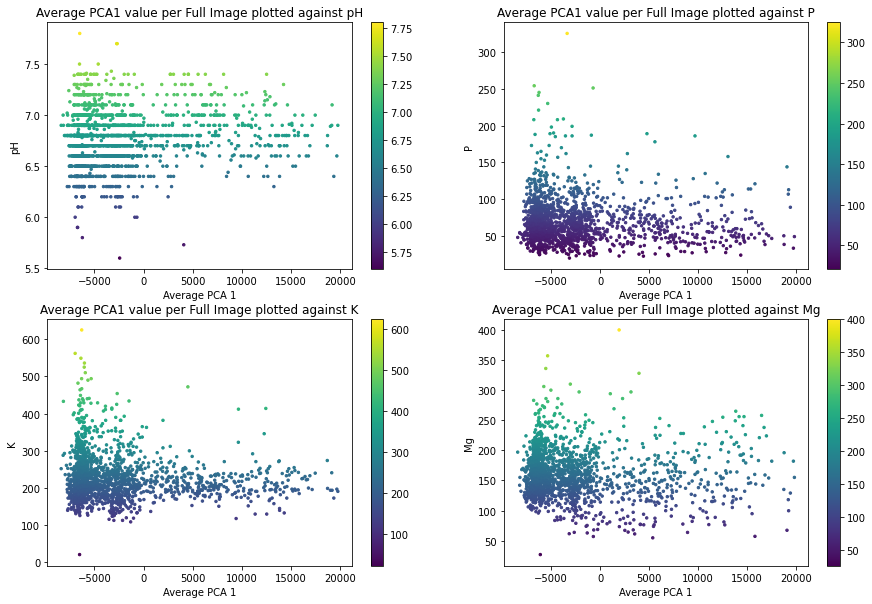

In [16]:
#Plot first PCA value against variables (holds highest variance)
plt.figure(figsize=(15, 10))
for i in range(0, len(depVars)):
    plt.subplot(2, 2, i+1)
    plt.scatter(avgPCA1, gt_df[depVars[i]], s = 6, c=gt_df[depVars[i]], cmap='viridis')
    plt.xlabel('Average PCA 1')
    plt.ylabel(depVars[i])
    plt.title(f"Average PCA1 value per Full Image plotted against {depVars[i]}")
    plt.colorbar()

## Download AveragePCA1 and AveragePCA2 values

In [17]:
from numpy import savetxt
averagedDF = pd.DataFrame({'avPCA1':maAvgPCA1,
                              'avPCA2':maAvgPCA2})
savetxt('mAveragedPCAs.csv', averagedDF, delimiter=',')